In [1]:
import glob
import os
import time
import csv

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ['CUDA_VISIBLE_DEVICES']='1'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.autograd import Variable
import torch.autograd as autograd
import torchvision.utils as vutils

from torch.utils.data import DataLoader, TensorDataset

In [2]:
def load_data():
    x_train = (h5py.File('camelyonpatch_level_2_split_train_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_train = h5py.File('camelyonpatch_level_2_split_train_y.h5', 'r')['y'][:].reshape(-1,1)
    x_test = (h5py.File('camelyonpatch_level_2_split_test_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_test = h5py.File('camelyonpatch_level_2_split_test_y.h5', 'r')['y'][:].reshape(-1,1)
    x_valid = (h5py.File('camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:, 16:80,16:80] - 127.5) / 127.5
    y_valid = h5py.File('camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:].reshape(-1,1)
              
    return x_train, y_train, x_test, y_test, x_valid, y_valid

def plot_samples(samples, folder=None, epoch=None, i=None):
    rt = int(np.sqrt(samples.shape[0]))
    r, c = rt, rt
    # r, c = 6, 12

    generatedImage = 0.5 * samples + 0.5

    fig = plt.figure(figsize=(10,10))

    axs = [fig.add_subplot(r,c,i+1) for i in range(r*c)]
    cnt = 0
    for ax in axs:
        ax.imshow(generatedImage[cnt],interpolation='nearest')
        ax.axis('off')
        ax.set_aspect('equal')
        cnt+=1
    fig.subplots_adjust(wspace=.004, hspace=.02)

    if folder:
        path = 'results/'+folder+'/samples'
        if not os.path.exists('results'):
            os.mkdir('results')
        if not os.path.exists('results/'+folder):
            os.mkdir('results/'+folder)
        if not os.path.exists(path):
            os.mkdir(path)
        step = ""
        if i:
            step = '_'+str(i)
        fig.savefig(path+'/epoch_%d%s.png' % (epoch, step))
        plt.close()


/home/aray/pathology_gan


(array([13054., 13160.]),
 array([0. , 0.5, 1. ], dtype=float32),
 <a list of 2 Patch objects>)

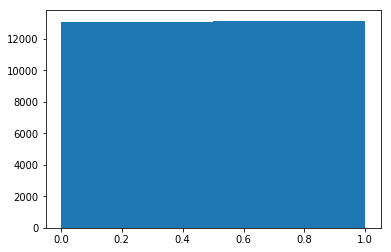

In [3]:
%cd "~/pathology_gan"

x_train, y_train, x_test, y_test, x_valid, y_valid = load_data()

x_train = torch.from_numpy(np.moveaxis(x_train.astype(np.float32), -1, 1))
x_test  = torch.from_numpy(np.moveaxis(x_test.astype(np.float32), -1, 1))
x_valid  = torch.from_numpy(np.moveaxis(x_valid.astype(np.float32), -1, 1))

y_train = torch.from_numpy(y_train).float() 
y_test = torch.from_numpy(y_test).float() 
y_valid = torch.from_numpy(y_valid).float() 

# X = torch.from_numpy(np.moveaxis(np.concatenate([x_train, x_test, x_valid]).astype(np.float32), -1, 1))
# y = torch.from_numpy(np.concatenate([y_train, y_test, y_valid]))

# trainloader = DataLoader(TensorDataset(x_train, y_train), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
validloader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

percent = int(x_train.shape[0]*.1)
np.random.seed(17)
idx_small = np.random.choice(range(x_train.shape[0]), percent, replace=False)

x_train_small = x_train[idx_small]
y_train_small = y_train[idx_small]
trainloader = DataLoader(TensorDataset(x_train_small, y_train_small), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

plt.hist(y_train_small.numpy(), bins=2)
# print(percent)

In [4]:
y_train_small = y_train_small.type(torch.LongTensor)
y_valid=y_valid.type(torch.LongTensor)
trainloader = DataLoader(TensorDataset(x_train_small, y_train_small), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
validloader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)


In [5]:
# noise = np.random.normal(0,1,size=(16,100))
# imgs = saved_actor.predict(noise)
# plot_samples(imgs)

# imgs_real = .5+.5*np.moveaxis(x_train[np.random.choice(range(x_train.shape[0]), 12*6, replace=False)], -1, 1)
# plot_samples(x_train[np.random.choice(range(x_train.shape[0]), 12*6, replace=False)])
# print(imgs_real.shape)
# plt.figure(figsize=(24,12))
# plt.imshow(np.transpose(make_grid(torch.from_numpy(imgs_real), nrow=12, ).numpy(), (1, 2, 0)))

In [14]:
class Generator(nn.Module):
    def __init__(self, w, h, c, latent_dim):
        super(Generator, self).__init__()
        
        self.w = w
        self.h = h
        self.c = c
        self.latent_dim = latent_dim
        
        self.input = nn.Sequential(
            nn.Linear(latent_dim, 32 * 16 * 16),
            nn.ReLU(),
            nn.BatchNorm1d(32 * 16 * 16),
        )
        
        self.deconv = nn.Sequential(
            nn.Upsample(size=[32, 32], mode='nearest'),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            
            nn.Upsample(size=[64, 64], mode='nearest'),
            nn.Conv2d(64, 48, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(48),
            
            nn.Upsample(size=[64, 64], mode='nearest'),
            nn.Conv2d(48, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(32),

            nn.Upsample(size=[128, 128], mode='nearest'),
            nn.Conv2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(8),

            nn.Upsample(size=[128, 128], mode='nearest'),
            nn.Conv2d(8, 16, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, c, 3, stride=1, padding=1),
            nn.Tanh()            
        )
        
    def forward(self, x):
        output = self.input(x)
        # print(output.shape)
        output = output.view(-1, 32, 16, 16)
        # print(output.shape)
        return self.deconv(output) #.view(-1, self.w, self.h, self.c)

class Discriminator(nn.Module):
    def __init__(self, h, w, c):
        super(Discriminator, self).__init__()
        
        self.w = w
        self.h = h
        self.c = c
        n_filters = 32

        self.conv = nn.Sequential(
            weight_norm(nn.Conv2d(c, n_filters, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(p=0.5),
            
            weight_norm(nn.Conv2d(n_filters, 2*n_filters, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(p=0.5),
                        
            weight_norm(nn.Conv2d(2*n_filters, 4*n_filters, 4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
       )
        self.fc = weight_norm(nn.Linear(4*n_filters*int(w/2**3)*int(h/2**3), 2, bias=True))

    def forward(self, x, clf=True, dropout=True):
        flatten = self.conv(x)
#         if dropout:
#             flatten = F.dropout(flatten, p=0.5)
        
        out = self.fc(flatten)
        
        if clf:
            return F.softmax(out, dim=1)

#         expsum = torch.exp(out).sum(dim=1)
#         out = expsum/(expsum+1)
        return out, flatten



In [12]:
class SSL_WGAN:
    def __init__(self, w, h, c, model_name, latent_dim=100):
        self.model_name = model_name
        self.latent_dim = latent_dim 
        self.lambda_gp = 10
        self.lambda_ct = 2
        self.d_iterations = 5
        self.print_every = 10
        # CT multiplier
        self.M = .1
        self.use_cuda = True
        self.D = Discriminator(w, h, c)
        self.G = Generator(w, h, c, latent_dim)

        lr = 1e-4
        betas = (.9, .99)

        self.Clf_opt = optim.Adam(self.D.parameters(), lr=lr)
        self.Clf_criterion = torch.nn.CrossEntropyLoss()
        
        self.D_opt = optim.Adam(self.D.parameters(), lr=lr)
        self.G_opt = optim.Adam(self.G.parameters(), lr=lr)


        if self.use_cuda:
            self.D = self.D.cuda()
            self.G = self.G.cuda()

        if not os.path.exists('results/'+model_name):
            os.mkdir('results/'+model_name)

    def train(self, train_loader, validation_loader, X_unlabled, epochs, save_training_gif=True):
        writer = SummaryWriter('/home/aray/runs/'+self.model_name)  
        if save_training_gif:
            # Fix latents to see how image generation improves during training
            self.fixed_latents = torch.randn((12*6, self.latent_dim))
            if self.use_cuda:
                self.fixed_latents = self.fixed_latents.cuda()
            self.training_progress_images = []

        self.stats = {
            'clf_loss': [],
            'clf_acc': [],
            'clf_loss_val': [],
            'clf_acc_val': [],
            'g_loss': [],
            'd_loss': [],
            'd_loss_real': [],
            'd_loss_fake': [],
            'gp': [],
            'ct': [],
            
        }

        for epoch in range(epochs):
            clf_loss = []
            clf_acc = []
            g_loss = []
            d_loss = []
            d_loss_fake = []
            d_loss_real = []
            gradient_penalty = []
            consistency_term = []

#             for i, data in tqdm(enumerate(train_loader), desc="epoch "+str(epoch)):
            for i, data in enumerate(train_loader):
#                 if i%((n_samples//128)//100)==0:
#                     print(".", end="", flush=True)
                X = data[0]
                y = data[1].view(-1)
                batch_size = X.shape[0]
                idx_u = np.random.choice(X_unlabled.shape[0], batch_size, replace=False)
                X_u = X_unlabled[idx_u]
                if self.use_cuda:
                    X_u = X_u.cuda()
                    X = X.cuda()
                    y = y.cuda()
                    
                loss, acc = self._train_Clf(X, y)
                clf_loss.append(loss)
                clf_acc.append(acc)                                
                    
                ct, loss = self._train_D(X_u)
#                 d_loss_real.append(r)
#                 d_loss_fake.append(g)
#                 gradient_penalty.append(gp)
                consistency_term.append(ct)
                d_loss.append(loss)
                
                # Only update generator every |d_iterations| iterations
#                 if i % self.d_iterations == 0:
                g_loss.append(self._train_G1(X_u))
            
            if epoch % 10 == 0:
                acc_val = self._eval_Clf(validation_loader)
                clf_loss_m = sum(clf_loss)/len(clf_loss)
                clf_acc_m = sum(clf_acc)/len(clf_acc)     
                g_loss_m = sum(g_loss)/len(g_loss)
                d_loss_m = sum(d_loss)/len(d_loss)
#                 real_m = sum(d_loss_real)/len(d_loss_real)
#                 fake_m = sum(d_loss_fake)/len(d_loss_fake)
#                 gp_m = sum(gradient_penalty)/len(gradient_penalty)
                ct_m = sum(consistency_term)/len(consistency_term)
                self.stats['clf_loss'].append(clf_loss_m)
                self.stats['clf_acc'].append(clf_acc_m)
    #             self.stats['clf_loss_val'].append(loss_val)
                self.stats['clf_acc_val'].append(acc_val)
                self.stats['g_loss'].append(g_loss_m)
                self.stats['d_loss'].append(d_loss_m)
#                 self.stats['d_loss_real'].append(real_m)
#                 self.stats['d_loss_fake'].append(fake_m)
#                 self.stats['gp'].append(gp_m)
                self.stats['ct'].append(ct_m)
                print("Epoch: %d, G loss: %f"%(epoch, g_loss_m))
                print("Clf loss: %f, acc: %.3f, acc_val: %.3f"%(clf_loss_m, clf_acc_m, acc_val))
                print("D loss: %f; ct: %f"%(d_loss_m, ct_m))
 
                writer.add_scalar('wgan_weight_nomr_ct', ct_m, epoch)
                writer.add_scalar('wgan_weight_nomr_d_loss', d_loss_m, epoch)
                writer.add_scalar('wgan_weight_nomr_g_loss', g_loss_m, epoch)
                writer.add_scalar('wgan_weight_nomr_clf_loss', clf_loss_m, epoch)
                writer.add_scalar('wgan_weight_nomr_clf_acc', clf_acc_m, epoch)
                writer.add_scalar('wgan_weight_nomr_acc_val', acc_val, epoch)

#             if epoch % 50 == 0:
#                 with torch.no_grad():
#                     self.G.eval()
# #                     self.D.eval()
# #                     print(self.D(X_unlabled[:10].cuda()).view(-1))
# #                     self.D.train()
#                     imgs = self.G(torch.randn((16, self.latent_dim)).cuda()).cpu().numpy()
#                     plot_samples(np.moveaxis(imgs, 1,-1), self.model_name, epoch)
#                     self.G.train()

            if  epoch % 10 == 0 and save_training_gif:
                with torch.no_grad():
                    self.G.eval()
                    img_grid = vutils.make_grid(self.G(self.fixed_latents).cpu(), nrow=12).numpy()
                    # (width, height, channels)
                    img_grid = .5+.5*np.transpose(img_grid, (1, 2, 0))
                    self.training_progress_images.append(img_grid)
                    writer.add_image('wgan_weight_nomr_images', img_grid, epoch, dataformats='HWC')
                    self.G.train()

            # if i % self.print_every == 0:
            #     print("Iteration {}".format(i + 1))
            #     print("D: {}".format(self.losses['D'][-1]))
            #     print("GP: {}".format(self.losses['GP'][-1]))
            #     print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
            #     if self.num_steps > self.critic_iterations:
            #         print("G: {}".format(self.losses['G'][-1]))

        if save_training_gif:
            imageio.mimsave('results/'+self.model_name+'/training_{}_epochs.gif'.format(epochs), self.training_progress_images)

    def _eval_Clf(self, validation_loader):
        self.D.eval()        
        with torch.no_grad():
            acc = .0
            for i, data in enumerate(validation_loader):
                X = data[0]
                y = data[1].view(-1)
                if self.use_cuda:
                    X = X.cuda()
                    y = y.cuda()
                predicted = torch.argmax(self.D(X), dim=1)
                acc+=(predicted == y).sum()/float(predicted.shape[0])       
        self.D.train()
        return (acc/(i+1)).detach().item()

    def _train_Clf(self, data, labels):
        self.Clf_opt.zero_grad()
        
        predicted = self.D(data, clf=True, dropout=True)
    
        loss = self.Clf_criterion(predicted, labels)
        
        loss.backward()
        self.Clf_opt.step()    
      
        acc = (torch.argmax(predicted.detach().cpu(), dim=1) == labels.detach().cpu()).sum()/float(predicted.shape[0])

        return loss.detach().item(), acc
        
#     def _D_loss(self, out):
#         expsum = torch.exp(out).sum(dim=1)
#         return expsum/(expsum+1)    
    
    def _train_D(self, data):
        self.D_opt.zero_grad()

        batch_size = data.shape[0]
        generated_data = self.sample_generator(batch_size)
        
#         l_lab = output_before_softmax_lab[T.arange(args.batch_size),labels] 
#         l_unl = nn.log_sum_exp(output_before_softmax_unl) 
#         l_gen = nn.log_sum_exp(output_before_softmax_gen)
#         loss_lab = -T.mean(l_lab) + T.mean(T.mean(nn.log_sum_exp(output_before_softmax_lab)))

#         loss_comp = T.mean(lasagne.objectives.squared_error(T.nnet.softmax(output_before_softmax_unl),T.nnet.softmax(output_before_softmax_unl2)))
#         loss_comp_ = T.mean(lasagne.objectives.squared_error(output_before_softmax_unl_,output_before_softmax_unl2_))

#         loss_unl = 0.05*loss_comp_ + 0.5*loss_comp -0.5*T.mean(l_unl) + 0.5*T.mean(T.nnet.softplus(l_unl)) -0.5*np.log(1) + 0.5*T.mean(T.nnet.softplus(l_gen))  

#         disc_param_updates = nn.adam_updates(disc_params, loss_lab + args.unlabeled_weight*loss_unl, lr=lr, mom1=0.5)
        
        real_fc1, real_flatten1 = self.D(data, clf=False)
        real_fc2, real_flatten2 = self.D(data, clf=False)
        gen_fc, _ = self.D(generated_data, clf=False)

#         ct1 = ((torch.softmax(real_fc1, dim=1) - torch.softmax(real_fc2, dim=1))**2).mean()
#         ct2 = ((torch.softmax(real_flatten1, dim=1) - torch.softmax(real_flatten2, dim=1))**2).mean()
    
        ct1 = (torch.softmax(real_fc1, dim=1) - torch.softmax(real_fc2, dim=1))**2
#         ct2 = (real_flatten1 - real_flatten2)**2
        
#         ct = 0.1(*0.5*ct1 + 0.05*ct2.mean())
        ct = 0.1*ct1.mean()

        real_lse = torch.logsumexp(real_fc1, dim=1)
        
        real_mean = F.softplus(real_lse).mean()
        gen_mean = F.softplus(torch.logsumexp(gen_fc, dim=1)).mean()

        d_loss = 0.5*(ct+real_mean + gen_mean - real_lse.mean())
        
        d_loss.backward()
        self.D_opt.step()


        return ct.detach().item(), d_loss.detach().item()

    
    def _train_G1(self, real_data):
        for p in self.D.parameters():
            p.requires_grad = False
            
        self.G_opt.zero_grad()

        batch_size = real_data.shape[0]
        generated_data = self.sample_generator(batch_size)

        _, d_real_output = self.D(real_data, clf=False, dropout=False)
        _, d_gen_output = self.D(generated_data, clf=False, dropout=False)

        g_loss = ((d_gen_output.mean(dim=0)-d_real_output.mean(dim=0))**2).mean()
        g_loss.backward()
        self.G_opt.step()
        
        for p in self.D.parameters():
            p.requires_grad = True

        return g_loss.detach().item()    

    def sample_generator(self, num_samples):
        latent_samples = torch.randn((num_samples, self.latent_dim), requires_grad=True)
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

In [10]:
def save_stats(model):
    with open('results/'+model.model_name+'/clf_acc.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['clf_acc'])

    with open('results/'+model.model_name+'/clf_loss.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['clf_loss'])

    with open('results/'+model.model_name+'/clf_acc_val.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['clf_acc_val'])
        
    with open('results/'+model.model_name+'/d_loss.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['d_loss'])

    with open('results/'+model.model_name+'/g_loss.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['g_loss'])

    with open('results/'+model.model_name+'/ct.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(model.stats['ct'])

def save_plots(model):
    path = 'results/'+model.model_name
    
    fig = plt.figure(figsize=(18,5))
    plt.plot(wgan_ct.stats['ct'], label='CT')
    plt.xlabel('Epochs x10')
    plt.ylabel('Loss')
    plt.legend()
    fig.savefig(path+'/ct.png')

    fig = plt.figure(figsize=(18,5))
    plt.plot(wgan_ct.stats['d_loss'], label='D')
    plt.plot(wgan_ct.stats['g_loss'], label='G')
    plt.xlabel('Epochs x10')
    plt.ylabel('Loss')
    plt.legend()
    fig.savefig(path+'/gan_loss.png')

    fig = plt.figure(figsize=(18,5))
    plt.plot(wgan_ct.stats['clf_loss'], label='Clf train')
    plt.xlabel('Epochs x10')
    plt.ylabel('Loss')
    plt.legend()
    fig.savefig(path+'/clf_train_loss.png')

    fig = plt.figure(figsize=(18,5))
    acc_max = np.max(wgan_ct.stats['clf_acc_val'])
    acc_max_e = np.argmax(wgan_ct.stats['clf_acc_val'])
    plt.axhline(y=acc_max, color='k', linestyle='-', alpha=0.2, linewidth=1)
    plt.axvline(x=acc_max_e, color='k', linestyle='-', alpha=0.2, linewidth=1)
    plt.plot(wgan_ct.stats['clf_acc'], label='Train')
    plt.plot(wgan_ct.stats['clf_acc_val'], label='Validation')
    plt.xlabel('Epochs x10')
    plt.ylabel('Acc')
    plt.legend()
    fig.savefig(path+'/clf_acc.png')


In [ ]:
wgan_ct = SSL_WGAN(64, 64, 3, 'ssl_wn_10')
wgan_ct.train(trainloader, validloader, x_train, 500, x_train.shape[0])
save_stats(wgan_ct)
save_plots(wgan_ct)
torch.save(wgan_ct.D.state_dict(), 'results/'+wgan_ct.model_name+'/D.pt')
torch.save(wgan_ct.G.state_dict(), 'results/'+wgan_ct.model_name+'/G.pt')


Epoch: 0, G loss: 0.008431
Clf loss: 0.632586, acc: 0.639, acc_val: 0.736
D loss: 0.416151; ct: 0.006047
Epoch: 10, G loss: 0.004059
Clf loss: 0.548845, acc: 0.752, acc_val: 0.765
D loss: 0.428434; ct: 0.003698
Epoch: 20, G loss: 0.006013
Clf loss: 0.544301, acc: 0.756, acc_val: 0.766
D loss: 0.399273; ct: 0.003922
Epoch: 30, G loss: 0.004186
Clf loss: 0.544524, acc: 0.758, acc_val: 0.770
D loss: 0.467871; ct: 0.003925
Epoch: 40, G loss: 0.003086
Clf loss: 0.540375, acc: 0.765, acc_val: 0.784
D loss: 0.495108; ct: 0.004237
Epoch: 50, G loss: 0.002383
Clf loss: 0.536181, acc: 0.769, acc_val: 0.791
D loss: 0.475838; ct: 0.004495
